In [78]:
import pandas as pd
import csv
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [72]:
# Load the dataset
df = pd.read_excel('lung_expression_data.xlsx').dropna()
df = df[df['GENE'] != 'NULL']

In [93]:
# Separate features and target
normal_columns = [col for col in df.columns if col.startswith(('AD', 'L')) and not col.startswith('LN')]
cancer_columns = [col for col in df.columns if col.startswith('LN')]

# Perform t-tests
p_values = []
for _, row in df.iterrows():
    cancer_values = row[cancer_columns].astype(float)
    normal_values = row[normal_columns].astype(float)
    p_value = ttest_ind(cancer_values, normal_values).pvalue
    p_values.append(p_value)

df['p_value'] = p_values

# Define overexpressed or underexpressed genes based on the p-value and the mean difference
df['is_cancer_mediator'] = ((df['p_value'] < 0.05) & (df[cancer_columns].mean(axis=1) > df[normal_columns].mean(axis=1))).astype(int)

In [94]:
# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df[cancer_columns + normal_columns], df['is_cancer_mediator'], test_size=0.2, random_state=42)

# Create a XGBoost Classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1160
           1       0.87      0.70      0.78       175

    accuracy                           0.95      1335
   macro avg       0.91      0.84      0.87      1335
weighted avg       0.95      0.95      0.95      1335



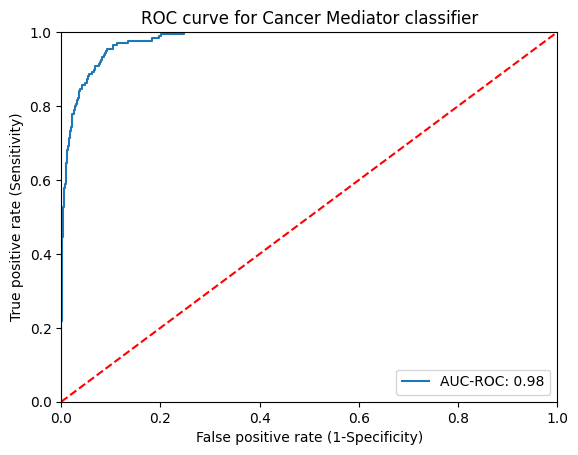

AUC-ROC: 0.9795221674876848
Accuracy: 0.947565543071161
Precision: 0.8723404255319149
Recall: 0.7028571428571428
F1 Score: 0.7784810126582278


In [95]:
# Plot ROC curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Mediator classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.legend(loc='lower right')
plt.show()

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [96]:
# Predict on the whole dataset to find all potential cancer mediating genes
df['predicted'] = clf.predict(df[cancer_columns + normal_columns])

# Export the predicted genes to a csv file
df.loc[df['predicted'] == 1, 'GENE'].to_csv('predicted_genes.csv', index=False)

In [97]:
# Read the CSV file into a list of lists
with open('newncbi_Lung.csv', 'r') as f:
    genes_and_aliases = [item.strip().upper() for sublist in csv.reader(f) for item in sublist]

# Check each predicted gene to see if it appears in the list of genes or aliases
predicted_genes = set(df.loc[df['predicted'] == 1, 'GENE'])
matches = predicted_genes.intersection(genes_and_aliases)
print(matches)

# Print the number of matches and non-matches
print(f"Out of {len(predicted_genes)} predicted genes, {len(matches)} were matched and {len(predicted_genes) - len(matches)} were not matched.")

{'SDF1', 'LPL', 'TIMP3', 'BCL2', 'GSTT1', 'HLA-DQA1', 'ABCB1', 'CASP8', 'CDKN1A', 'NR4A1', 'PTHR1', 'IL1B', 'PSAP', 'PPARG', 'DAF', 'ASPA', 'ENG', 'VASP', 'SDC4', 'ETS1', 'MME', 'TNFRSF6', 'TGFBR3', 'BCL2L2', 'GAS6', 'AXL', 'COMT', 'XPC', 'S100A4', 'SFTPA1', 'IGF1', 'DPYD', 'UBC', 'LGALS2', 'ACTA2', 'SRF', 'ALDH1', 'FGF2', 'CREB1', 'TIMP2', 'ITGA5', 'CAV1', 'FHL1', 'LGALS1', 'CX3CR1', 'CD44', 'FOXF1', 'PXN', 'ICAM1', 'MADH7', 'SCYA2', 'CD97', 'NR4A2', 'HEF1', 'SELP', 'TRIP10', 'TJP1', 'RASSF2', 'PBP', 'NFE2L2', 'FGF9', 'HLF', 'IRF1', 'FBLN2', 'CYP2A13', 'AQP1', 'FOLR1', 'CLDN5', 'ADRB2', 'ALOX5', 'APC', 'ID3', 'ANXA3', 'PRKCM', 'LLGL1', 'RBL2', 'GPC3', 'FGFR2', 'LGALS3', 'AGER', 'MT1G', 'TBXAS1', 'SOD3', 'MCAM', 'CCND2', 'PTGER4', 'SFTPC', 'VIM', 'FOS', 'SELE', 'LSP1', 'EDNRB', 'EGR1', 'SFTPA2', 'GSN', 'GJA1', 'ARHA', 'CAT', 'COPEB', 'CXCR4', 'ANGPT1', 'GATA6', 'GLI', 'SATB1', 'ALK', 'IL6', 'TGFBR2', 'EFEMP1', 'BAP1', 'MHCBFB', 'MADH6', 'KLF4', 'SCYA5', 'PIK3R3', 'PTGER1', 'RB1', 'MSN'